# Set up environment

In [32]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch

# 数据准备

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
tech_daily = pd.read_csv(r"data\科技股票.csv")
tech_daily.set_index('date', inplace=True)
tech_daily.columns=['AAPL','GOOG','MSFT']
tech_daily

,AAPL,GOOG,MSFT
date,,,
2022-01-03,178.270326,144.088458,324.504611
2022-01-04,176.007789,143.434930,318.940290
2022-01-05,171.326001,136.717897,306.696845
2022-01-06,168.465997,136.616093,304.273361
2022-01-07,168.632504,136.073308,304.428464
...,...,...,...
2025-11-03,268.789439,284.120000,517.030000
2025-11-04,269.778480,278.060000,514.330000
2025-11-05,269.878383,284.750000,507.160000


In [35]:
debt=pd.read_csv(r"data\无风险.csv",encoding='gbk')
debt.set_index('date', inplace=True)
debt.columns=['US_debt']
debt

,US_debt
date,
2022-01-03,1.63
2022-01-04,1.66
2022-01-05,1.71
2022-01-06,1.73
2022-01-07,1.76
...,...
2025-11-03,4.13
2025-11-04,4.10
2025-11-05,4.17


In [36]:
tmp=pd.read_csv(r"data\指数和贵金属.csv", encoding='gbk')
tmp.columns=['date','SP500','Gold']
tmp.set_index('date', inplace=True)
tmp

,SP500,Gold
date,,
2022-01-03,4796.56,1801.3
2022-01-04,4793.54,1814.9
2022-01-05,4700.58,1810.6
2022-01-06,4696.05,1790.9
2022-01-07,4677.03,1796.5
...,...,...
2025-11-03,6851.97,4013.7
2025-11-04,6771.55,3941.3
2025-11-05,6796.29,3990.4


In [37]:
df=pd.merge(tech_daily,debt,how='left',on='date')
df=pd.merge(df,tmp,how='left',on='date')
df['date']=pd.to_datetime(df.index)
df.set_index('date', inplace=True)
df[df.isnull().values == True]

,AAPL,GOOG,MSFT,US_debt,SP500,Gold
date,,,,,,
2022-10-10,138.103983,98.039090,223.685532,NaN,3612.39,1675.7
2022-11-11,147.475157,96.072547,241.112025,NaN,3992.93,1774.2
2023-10-09,177.082149,138.551849,324.923430,NaN,4335.66,1875.0
2024-10-14,230.005541,165.625113,416.016745,NaN,5859.85,2665.8
2024-11-11,223.220427,181.177047,414.895165,NaN,6001.35,2626.1
2025-10-13,247.420154,244.640000,514.050000,NaN,6654.72,4130.0


In [38]:
df.interpolate(method='time', inplace=True)
df

,AAPL,GOOG,MSFT,US_debt,SP500,Gold
date,,,,,,
2022-01-03,178.270326,144.088458,324.504611,1.63,4796.56,1801.3
2022-01-04,176.007789,143.434930,318.940290,1.66,4793.54,1814.9
2022-01-05,171.326001,136.717897,306.696845,1.71,4700.58,1810.6
2022-01-06,168.465997,136.616093,304.273361,1.73,4696.05,1790.9
2022-01-07,168.632504,136.073308,304.428464,1.76,4677.03,1796.5
...,...,...,...,...,...,...
2025-11-03,268.789439,284.120000,517.030000,4.13,6851.97,4013.7
2025-11-04,269.778480,278.060000,514.330000,4.10,6771.55,3941.3
2025-11-05,269.878383,284.750000,507.160000,4.17,6796.29,3990.4


In [39]:
from math import inf

from networkx import sigma
from pyparsing import deque

class PortfolioOptimizationEnv(gym.Env):
    def __init__(self, tickers, window_size, start_date, end_date,
                 initial_balance, seed=None):
        super().__init__()
        self.tickers = tickers
        self.window_size = window_size
        self.initial_balance = initial_balance

        # 分别存储原始价格和指标
        self.raw_data, self.feature_data = self.get_data(tickers, start_date, end_date)
        self.n_features = self.feature_data.shape[1]
        
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(len(tickers),))
        self.observation_space = gym.spaces.Box(low=-inf, high=inf,
                                        shape=(window_size, self.n_features))
        
        self.return_window=deque(maxlen=window_size)
        self.last_action=np.ones(len(tickers))/len(tickers)

        if seed is not None:
            np.random.seed(seed)
            self.action_space.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_data(self, tickers, start_date, end_date):
        data = df.copy().dropna()
        data = data.loc[start_date:end_date, tickers]
        
        # 保存原始价格（用于计算投资组合收益）
        raw_data = data.copy()
        
        # 计算特征指标
        returns = data.pct_change()
        
        mom_frames = []
        for window in [5, 20]:
            mom = data / data.shift(window) - 1
            mom.columns = [f"{col}_mom_{window}" for col in data.columns]
            mom_frames.append(mom)

        vol = returns.rolling(window=20, min_periods=1).std()
        vol.columns = [f"{col}_vol_20" for col in data.columns]

        ma = data.rolling(window=20, min_periods=1).mean()
        ma_dev = data / ma - 1
        ma_dev.columns = [f"{col}_ma_dev_20" for col in data.columns]

        returns.columns = [f"{col}_ret" for col in data.columns]
        
        # 特征数据：returns, vol, ma_dev, momentum（不包含原始价格）
        feature_data = pd.concat([returns, vol, ma_dev] + mom_frames, axis=1)
        raw_data = raw_data.dropna()
        feature_data = feature_data.reindex(raw_data.index)
        feature_data.fillna(method='ffill', inplace=True)
        feature_data.fillna(method='bfill', inplace=True)

        return raw_data.dropna(), feature_data.dropna()

    def reset(self, seed=None):
        self.balance = self.initial_balance
        self.current_step = self.window_size

        self.return_window.clear()
        self.last_action = np.ones(len(self.tickers)) / len(self.tickers)
        
        # 使用特征数据作为观察
        obs = self.feature_data.iloc[self.current_step - self.window_size:self.current_step].values
        info = {"balance": self.balance}
        return obs, info

    def step(self, action):
        action = action / (np.sum(action) + 1e-8)

        prev_balance = self.balance
        
        # 从原始价格计算实际收益
        current_price = self.raw_data.iloc[self.current_step].values[:len(self.tickers)]
        prev_price = self.raw_data.iloc[self.current_step - 1].values[:len(self.tickers)]
        asset_returns = current_price / prev_price - 1
        
        self.return_window.append(asset_returns)

        # 基础奖励：投资组合收益
        portfolio_return = np.sum(asset_returns * action)
        self.balance = self.balance * (1 + portfolio_return)
        base_reward = np.log(self.balance / prev_balance)

        risk_penalty = 0
        if len(self.return_window)>=5:
            R=np.vstack(self.return_window)
            cov_matrix=np.cov(R.T)
            sigma_p2= action.T @ cov_matrix @ action
            sigma_p=np.sqrt(sigma_p2)
            lambda_vol=5
            risk_penalty = -lambda_vol * sigma_p
        
        turnover=np.sum(np.abs(action - self.last_action))
        cost= 0.001 * turnover
        self.last_action=action
        
        # 总奖励
        reward = base_reward + risk_penalty - cost
        
        self.current_step += 1
        done = self.current_step >= len(self.raw_data)-1

        obs_end=min(len(self.feature_data),self.current_step+self.window_size)
        obs_start=max(0,obs_end - self.window_size)
        obs = self.feature_data.iloc[obs_start:obs_end].values

        terminated = bool(done)
        truncated = False
        info = {'balance': self.balance}

        return obs, reward, terminated, truncated, info

In [40]:
tickers = df.columns.tolist()
window_size = 30
start_date = '2022-01-01'
end_date = '2025-09-01'
initial_balance = 10000
seed = 8

# Initialize the environment
env = PortfolioOptimizationEnv(
    tickers,
    window_size,
    start_date,
    end_date,
    initial_balance,
    seed)

# Get the initial state
state = env.reset(seed=seed)
# Sample and execute a random action
action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)
done = bool(terminated or truncated)
# print(f"State: {state}")
print(f"Action: {action}")
# print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Balance: {info['balance']}")
print(f"Done: {done}")


Action: [0.32697228 0.98727685 0.31871083 0.78854895 0.86989653 0.39108482]
Reward: 0.015598913072904633
Balance: 10161.65097308565
Done: False


C:\Users\HP\AppData\Local\Temp\ipykernel_27388\2914642385.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method='ffill', inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_27388\2914642385.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method='bfill', inplace=True)


# Training DRL agent

## PPO

C:\Users\HP\AppData\Local\Temp\ipykernel_27388\2914642385.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method='ffill', inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_27388\2914642385.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method='bfill', inplace=True)
d:\Develop\miniconda\envs\py310\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU ut

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 887      |
|    ep_rew_mean     | -53.2    |
| time/              |          |
|    fps             | 333      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 887         |
|    ep_rew_mean          | -53.1       |
| time/                   |             |
|    fps                  | 273         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.032681793 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.52       |
|    explained_variance   | -1.17       |
|    learnin

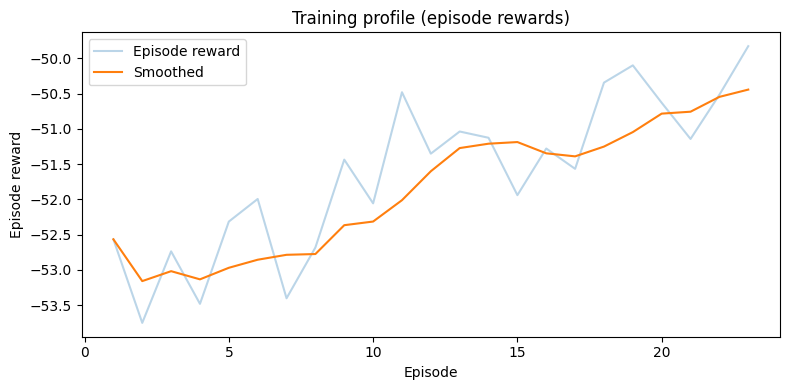

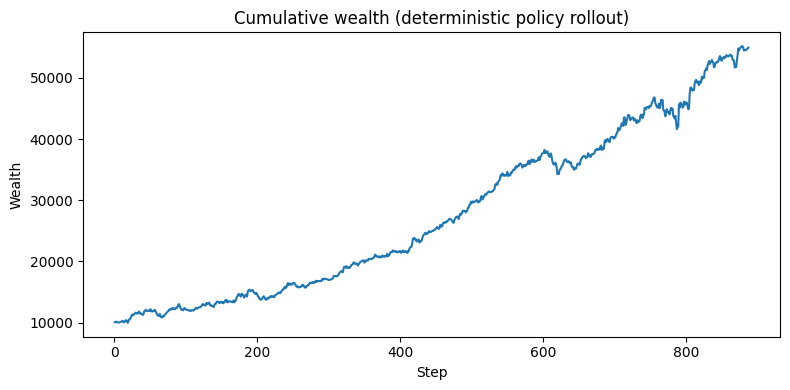


=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10055.45
End wealth:    54941.09
Total growth:  5.463811
CAGR:          62.092061%
Ann. Return (geom from equity): 62.092061%
Ann. Vol:      17.712724%
Sharpe (rf=0): 2.8174
Max Drawdown:  -11.18%
Calmar:        5.5563


In [41]:
# ===== Train PPO + plot training profile + plot cumulative wealth + print metrics =====
# Prereqs (run once in your env if needed):
#   pip install "stable-baselines3>=2.3.0" "shimmy>=2.0" matplotlib pandas

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.vec_env import VecNormalize

# ------------ 1) Build vectorized env (wrap with Monitor to log training rewards) ------------
log_dir = "./sb3_logs"
os.makedirs(log_dir, exist_ok=True)
monitor_path = os.path.join(log_dir, "monitor.csv")

def make_env():
    env_ = PortfolioOptimizationEnv(
        tickers=tickers,
        window_size=window_size,
        start_date=start_date,
        end_date=end_date,
        initial_balance=initial_balance,
        seed=seed,
    )
    # Log episode reward/length; include "balance" from info if you want (optional)
    env_ = Monitor(env_, filename=monitor_path)  # single-env -> single monitor file
    return env_

vec_env = DummyVecEnv([make_env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.)

# ------------ 2) Train PPO ------------
model = PPO(
    "MlpPolicy", vec_env, verbose=1, device=device
)  # PPO（近端策略优化）：适合连续动作空间，训练稳定，是投资组合优化的常用算法
model.learn(total_timesteps=20000)  # increase as needed
model.save("ppo_portfolio_optimization")

# ------------ 3) Load training profile (episode rewards) and plot ------------
# SB3 Monitor CSV starts with commented metadata lines beginning with '#'
train_df = pd.read_csv(monitor_path, comment="#")
# Columns typically: r (ep reward), l (ep length), t (time)
# Make a simple moving average of episode rewards for a smooth training curve
if len(train_df) > 0:
    train_df["ep"] = np.arange(1, len(train_df) + 1)
    train_df["reward_smooth"] = train_df["r"].rolling(window=max(5, len(train_df)//50), min_periods=1).mean()

    plt.figure(figsize=(8, 4))
    plt.plot(train_df["ep"], train_df["r"], alpha=0.3, label="Episode reward")
    plt.plot(train_df["ep"], train_df["reward_smooth"], label="Smoothed")
    plt.xlabel("Episode")
    plt.ylabel("Episode reward")
    plt.title("Training profile (episode rewards)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No episodes logged in monitor file (did training terminate too early?).")

# ------------ 4) Roll out a full episode deterministically and record balances ------------
obs = vec_env.reset()
dones = [False]
balances = []
rewards = []
weights_seq = []

while not dones[0]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, dones, infos = vec_env.step(action)
    rewards.append(float(reward[0]))
    balances.append(float(infos[0].get("balance", np.nan)))
    weights_seq.append(infos[0].get("weights", None))

# Try to build a date index for nicer plotting/annualization
try:
    # Access the underlying single env inside DummyVecEnv -> Monitor -> PortfolioOptimizationEnv
    base_env = vec_env.envs[0].env
    # For safety if nested wrappers differ:
    while hasattr(base_env, "env"):
        base_env = base_env.env
    price_index = base_env.data.index  # pandas.DatetimeIndex from your env
    # The first balance corresponds to the first step after initial window
    # Align dates accordingly:
    start_idx = window_size
    end_idx = start_idx + len(balances)
    dates = price_index[start_idx:end_idx]
except Exception:
    dates = pd.RangeIndex(start=1, stop=len(balances) + 1)  # fallback to simple index

# ------------ 5) Plot cumulative wealth curve ------------
plt.figure(figsize=(8, 4))
plt.plot(dates, balances)
plt.xlabel("Date" if isinstance(dates, pd.DatetimeIndex) else "Step")
plt.ylabel("Wealth")
plt.title("Cumulative wealth (deterministic policy rollout)")
plt.tight_layout()
plt.show()

# ------------ 6) Compute portfolio performance metrics ------------
# Step simple returns from balance path
balances_arr = np.asarray(balances, dtype=float)
rets = balances_arr[1:] / balances_arr[:-1] - 1.0 if len(balances_arr) > 1 else np.array([])

# Infer periods per year from dates if possible; else default 252
def infer_ppy(idx):
    if isinstance(idx, pd.DatetimeIndex) and len(idx) >= 2:
        # Use median days between points
        deltas = np.diff(idx.view("int64")) / 1e9 / 86400.0  # ns -> days
        median_days = np.median(deltas) if len(deltas) else 1.0
        if median_days <= 0:
            return 252.0
        return 365.25 / median_days
    return 252.0

PPY = infer_ppy(dates)

def max_drawdown(equity):
    peak = np.maximum.accumulate(equity)
    dd = (equity - peak) / peak
    return float(dd.min()) if len(dd) else 0.0

if len(rets) > 0:
    total_growth = balances_arr[-1] / balances_arr[0]
    N = len(rets)
    CAGR = total_growth ** (PPY / N) - 1.0 # PPY：每年交易天数；CAGR：年复合增长率
    mean_r = float(np.mean(rets))
    std_r = float(np.std(rets, ddof=1)) if N > 1 else 0.0
    ann_return = (1.0 + mean_r) ** PPY - 1.0 if mean_r > -1 else np.nan  # geometric approx alternative below
    ann_vol = std_r * np.sqrt(PPY) if std_r > 0 else 0.0
    # Sharpe (rf=0 for simplicity; replace with your risk-free rate if desired)
    rf = 0.0
    sharpe = (mean_r - rf/PPY) / std_r * np.sqrt(PPY) if std_r > 0 else np.nan
    mdd = max_drawdown(balances_arr)
    calmar = (CAGR / abs(mdd)) if mdd != 0 else np.nan

    # Alternative geometric annualized return from total growth (more stable):
    ann_return_geom = total_growth ** (PPY / N) - 1.0

    print("\n=== Portfolio Performance (deterministic rollout) ===")
    print(f"Periods per year (inferred): {PPY:.2f}")
    print(f"Start wealth:  {balances_arr[0]:.2f}")
    print(f"End wealth:    {balances_arr[-1]:.2f}")
    print(f"Total growth:  {total_growth:.6f}")
    print(f"CAGR:          {CAGR:.6%}")
    print(f"Ann. Return (geom from equity): {ann_return_geom:.6%}")
    print(f"Ann. Vol:      {ann_vol:.6%}")
    print(f"Sharpe (rf=0): {sharpe:.4f}")
    print(f"Max Drawdown:  {mdd:.2%}")
    print(f"Calmar:        {calmar:.4f}")
else:
    print("Not enough steps to compute metrics (need at least 2 balances).")

# ------------ 7) (Optional) Inspect last action weights ------------
if any(w is not None for w in weights_seq):
    last_w = [w for w in weights_seq if w is not None][-1]
    print("\nLast portfolio weights:", np.round(last_w, 4))

## A2C

Using cuda device


C:\Users\HP\AppData\Local\Temp\ipykernel_27388\2914642385.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method='ffill', inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_27388\2914642385.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method='bfill', inplace=True)
d:\Develop\miniconda\envs\py310\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU ut

------------------------------------
| time/                 |          |
|    fps                | 236      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -8.55    |
|    explained_variance | -39.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.959    |
|    std                | 1.01     |
|    value_loss         | 0.0216   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 887      |
|    ep_rew_mean        | -50.7    |
| time/                 |          |
|    fps                | 237      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -8.57    |
|    explained_variance | -2.61    |
|

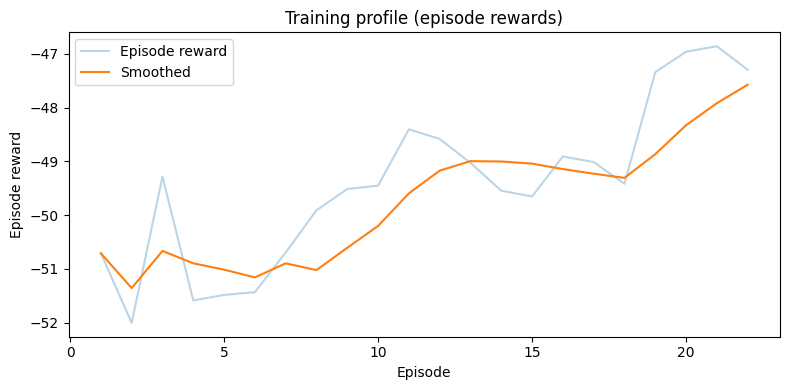

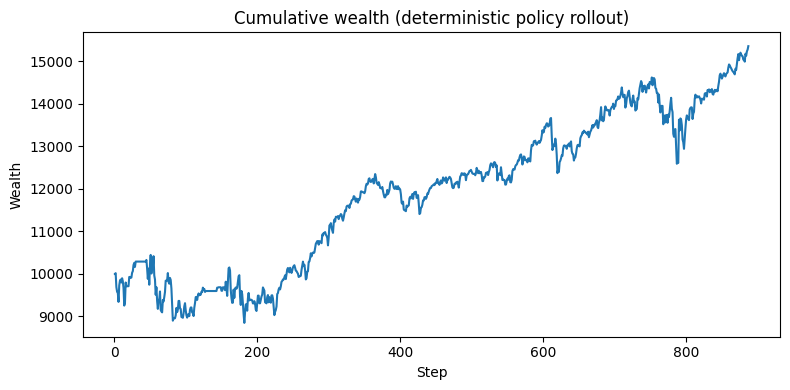


=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10000.00
End wealth:    15353.61
Total growth:  1.535361
CAGR:          12.969926%
Ann. Return (geom from equity): 12.969926%
Ann. Vol:      17.650193%
Sharpe (rf=0): 0.7793
Max Drawdown:  -15.29%
Calmar:        0.8483


In [42]:
# ===== Train PPO + plot training profile + plot cumulative wealth + print metrics =====
# Prereqs (run once in your env if needed):
#   pip install "stable-baselines3>=2.3.0" "shimmy>=2.0" matplotlib pandas

from stable_baselines3 import A2C

# ------------ 1) Build vectorized env (wrap with Monitor to log training rewards) ------------
log_dir = "./sb3_logs"
os.makedirs(log_dir, exist_ok=True)
monitor_path = os.path.join(log_dir, "monitor.csv")


def make_env():
    env_ = PortfolioOptimizationEnv(
        tickers=tickers,
        window_size=window_size,
        start_date=start_date,
        end_date=end_date,
        initial_balance=initial_balance,
        seed=seed,
    )
    # Log episode reward/length; include "balance" from info if you want (optional)
    env_ = Monitor(env_, filename=monitor_path)  # single-env -> single monitor file
    return env_


vec_env = DummyVecEnv([make_env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# ------------ 2) Train A2C ------------
model = A2C(
    "MlpPolicy", vec_env, verbose=1, device=device
)  # A2C（优势行动者评论家）：适合连续动作空间，训练稳定，是投资组合优化的常用算法
model.learn(total_timesteps=20000)  # increase as needed
model.save("a2c_portfolio_optimization")

# ------------ 3) Load training profile (episode rewards) and plot ------------
# SB3 Monitor CSV starts with commented metadata lines beginning with '#'
train_df = pd.read_csv(monitor_path, comment="#")
# Columns typically: r (ep reward), l (ep length), t (time)
# Make a simple moving average of episode rewards for a smooth training curve
if len(train_df) > 0:
    train_df["ep"] = np.arange(1, len(train_df) + 1)
    train_df["reward_smooth"] = (
        train_df["r"].rolling(window=max(5, len(train_df) // 50), min_periods=1).mean()
    )

    plt.figure(figsize=(8, 4))
    plt.plot(train_df["ep"], train_df["r"], alpha=0.3, label="Episode reward")
    plt.plot(train_df["ep"], train_df["reward_smooth"], label="Smoothed")
    plt.xlabel("Episode")
    plt.ylabel("Episode reward")
    plt.title("Training profile (episode rewards)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No episodes logged in monitor file (did training terminate too early?).")

# ------------ 4) Roll out a full episode deterministically and record balances ------------
obs = vec_env.reset()
dones = [False]
balances = []
rewards = []
weights_seq = []

while not dones[0]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, dones, infos = vec_env.step(action)
    rewards.append(float(reward[0]))
    balances.append(float(infos[0].get("balance", np.nan)))
    weights_seq.append(infos[0].get("weights", None))

# Try to build a date index for nicer plotting/annualization
try:
    # Access the underlying single env inside DummyVecEnv -> Monitor -> PortfolioOptimizationEnv
    base_env = vec_env.envs[0].env
    # For safety if nested wrappers differ:
    while hasattr(base_env, "env"):
        base_env = base_env.env
    price_index = base_env.data.index  # pandas.DatetimeIndex from your env
    # The first balance corresponds to the first step after initial window
    # Align dates accordingly:
    start_idx = window_size
    end_idx = start_idx + len(balances)
    dates = price_index[start_idx:end_idx]
except Exception:
    dates = pd.RangeIndex(start=1, stop=len(balances) + 1)  # fallback to simple index

# ------------ 5) Plot cumulative wealth curve ------------
plt.figure(figsize=(8, 4))
plt.plot(dates, balances)
plt.xlabel("Date" if isinstance(dates, pd.DatetimeIndex) else "Step")
plt.ylabel("Wealth")
plt.title("Cumulative wealth (deterministic policy rollout)")
plt.tight_layout()
plt.show()

# ------------ 6) Compute portfolio performance metrics ------------
# Step simple returns from balance path
balances_arr = np.asarray(balances, dtype=float)
rets = (
    balances_arr[1:] / balances_arr[:-1] - 1.0
    if len(balances_arr) > 1
    else np.array([])
)


# Infer periods per year from dates if possible; else default 252
def infer_ppy(idx):
    if isinstance(idx, pd.DatetimeIndex) and len(idx) >= 2:
        # Use median days between points
        deltas = np.diff(idx.view("int64")) / 1e9 / 86400.0  # ns -> days
        median_days = np.median(deltas) if len(deltas) else 1.0
        if median_days <= 0:
            return 252.0
        return 365.25 / median_days
    return 252.0


PPY = infer_ppy(dates)


def max_drawdown(equity):
    peak = np.maximum.accumulate(equity)
    dd = (equity - peak) / peak
    return float(dd.min()) if len(dd) else 0.0


if len(rets) > 0:
    total_growth = balances_arr[-1] / balances_arr[0]
    N = len(rets)
    CAGR = total_growth ** (PPY / N) - 1.0  # PPY：每年交易天数；CAGR：年复合增长率
    mean_r = float(np.mean(rets))
    std_r = float(np.std(rets, ddof=1)) if N > 1 else 0.0
    ann_return = (
        (1.0 + mean_r) ** PPY - 1.0 if mean_r > -1 else np.nan
    )  # geometric approx alternative below
    ann_vol = std_r * np.sqrt(PPY) if std_r > 0 else 0.0
    # Sharpe (rf=0 for simplicity; replace with your risk-free rate if desired)
    rf = 0.0
    sharpe = (mean_r - rf / PPY) / std_r * np.sqrt(PPY) if std_r > 0 else np.nan
    mdd = max_drawdown(balances_arr)
    calmar = (CAGR / abs(mdd)) if mdd != 0 else np.nan

    # Alternative geometric annualized return from total growth (more stable):
    ann_return_geom = total_growth ** (PPY / N) - 1.0

    print("\n=== Portfolio Performance (deterministic rollout) ===")
    print(f"Periods per year (inferred): {PPY:.2f}")
    print(f"Start wealth:  {balances_arr[0]:.2f}")
    print(f"End wealth:    {balances_arr[-1]:.2f}")
    print(f"Total growth:  {total_growth:.6f}")
    print(f"CAGR:          {CAGR:.6%}")
    print(f"Ann. Return (geom from equity): {ann_return_geom:.6%}")
    print(f"Ann. Vol:      {ann_vol:.6%}")
    print(f"Sharpe (rf=0): {sharpe:.4f}")
    print(f"Max Drawdown:  {mdd:.2%}")
    print(f"Calmar:        {calmar:.4f}")
else:
    print("Not enough steps to compute metrics (need at least 2 balances).")

# ------------ 7) (Optional) Inspect last action weights ------------
if any(w is not None for w in weights_seq):
    last_w = [w for w in weights_seq if w is not None][-1]
    print("\nLast portfolio weights:", np.round(last_w, 4))

# 修改部分

添加了科技股票、国债、标普500和黄金等数据作为环境输入特征

## 收益严重偏大，进行修改：

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10297.47
End wealth:    23731074.08
Total growth:  2304.553868
CAGR:          804.485651%
Ann. Return (geom from equity): 804.485651%
Ann. Vol:      22.710210%
Sharpe (rf=0): 9.8502
Max Drawdown:  -5.59%
Calmar:        143.9561

### 1、对vec_env进行了归一化处理

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10180.25
End wealth:    1013360.39
Total growth:  99.541782
CAGR:          270.067928%
Ann. Return (geom from equity): 270.067928%
Ann. Vol:      22.074986%
Sharpe (rf=0): 6.0514
Max Drawdown:  -8.50%
Calmar:        31.7818

### 2、调整奖励函数
用协方差矩阵估计组合波动
添加每次交易成本千一

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10055.45
End wealth:    54941.09
Total growth:  5.463811
CAGR:          62.092061%
Ann. Return (geom from equity): 62.092061%
Ann. Vol:      17.712724%
Sharpe (rf=0): 2.8174
Max Drawdown:  -11.18%
Calmar:        5.5563

### 3、添加了a2c算法